In [1]:
import numpy                as np
import pandas               as pd
import matplotlib.pyplot    as plt
import matplotlib.patches  as patches
import matplotlib.gridspec as gridspec

from scipy                   import optimize
from scipy.integrate         import quad
from scipy.optimize          import minimize

In [2]:
# Plotting style
figure_size  = 10, 5
#font_size    = 16

plt.rcParams["figure.figsize"] =   figure_size
#plt.rcParams[  "font.size"   ] =   font_size

plt.style.use(plt.style.available[10])
nbins=100

## EVENT SELECTION AND PERCENTAGES

In [3]:
run =6206
typo='Tlds'
df = pd.HDFStore(f'../corrections_{run}_{typo}.h5')['/edf']

Emax, Emin = 430e3, 380e3
edf = df[(df.e<Emax) & (df.e>Emin) &(df.peak==0)]

def F(E, Eph, sig, A, m, c):
    return A * np.e**(-(E-Eph)**2/(2*sig**2)) + m*(E-Emin) + c

def chisq(F, popt, xdata, ydata):
    return np.sum((F(xdata, *popt)-ydata)**2/((len(xdata)-len(popt))*ydata))

nbins=100
ydata, xdata = np.histogram(edf['e'], bins=nbins, range=(Emin, Emax))
xdata = np.array([(xdata[i+1] + xdata[i])/2 for i in range(0, len(xdata)-1)])

guess = [np.mean(edf['e']), np.std(edf['e']), np.max(ydata), -1, np.mean(ydata)]
popt, pcov = optimize.curve_fit(F, xdata, ydata, p0 = guess, sigma = np.sqrt(ydata),
                               bounds=([-np.inf, 0, -np.inf, -np.inf, -np.inf], np.inf))

Eph, sig, A, m, c = popt[0], popt[1], popt[2], popt[3], popt[4]

In [4]:
# Percentages
Ea_pk, Eb_pk = 390e3, 410e3 #integration region
Ea_bk, Eb_bk = 410e3, Emax

It,_ = quad(F, Ea_pk, Eb_pk, args=tuple(popt))
I1e = (Eb_pk-Ea_pk)*(m*(Ea_pk-Emin)+c + 0.5*(m*Eb_pk-m*Ea_pk))

e1, e2 = I1e/It, 1-I1e/It

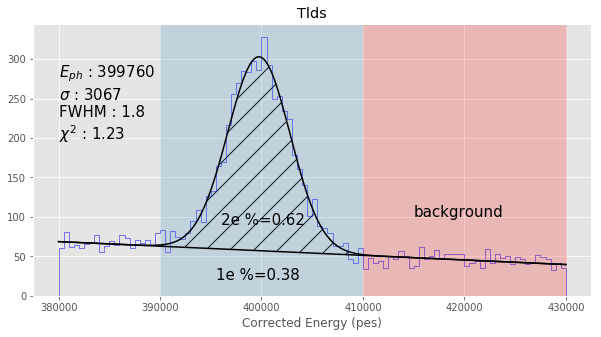

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(edf['e'], bins=nbins, color='b', histtype='step');
E = np.linspace(Emin, Emax, 2*nbins);
ax.plot(E, F(E, *popt), color = 'black');
ax.plot(E, m*(E-Emin)+c, color='black');

E = np.linspace(Ea_pk, Eb_pk, 2*nbins);
ax.fill_between(E, m*(E-Emin)+c, F(E, *popt), hatch='/', alpha=0);
#ax.fill()

rect = patches.Rectangle(xy=(Ea_pk,0), width=Eb_pk-Ea_pk, height=350, alpha=0.2)
ax.add_patch(rect)

rect_bk = patches.Rectangle(xy=(Ea_bk,0), width=Eb_pk-Ea_pk, height=350, alpha=0.2, color='r')
ax.add_patch(rect_bk)

t = (r"$E_{{ph}}$ : {}"     .format(int(Eph)) + 
     "\n" + "$\sigma$ : {}" .format(int(sig)) +
     "\n" + r"FWHM : {}"    .format(round(sig / Eph * 235, 2)) + 
     "\n" + r"$\chi^2$ : {}".format(round(chisq(F, popt, xdata, ydata),2))) 

ax.text(380e3, 200, s = t, fontsize = 15);

t1 = (f'1e %={round(e1,2)}')
ax.text(395.5e3, 20, s = t1, fontsize = 15);

t2 = (f'2e %={round(e2,2)}')
ax.text(396e3, 90, s = t2, fontsize = 15, color='black');

ax.text(415e3, 100, s='background', fontsize=15)

ax.set_xlabel('Corrected Energy (pes)');
ax.set_title('{}'.format(typo));

## BLOB ENERGY DISTRIBUTIONS

In [6]:
bldir = f'/home/gonzalo/Documentos/NEXT/CsThNB/GDL/blobcalc/DATA/{run}'

In [37]:
bsize = 17

bbdf_pk = pd.HDFStore(f'{bldir}/blobsdf_pk__6206_Tlds_{bsize}_1_1_no.h5')['blobs']
bbdf_bk = pd.HDFStore(f'{bldir}/blobsdf_bk__6206_Tlds_{bsize}_1_1_no.h5')['blobs']

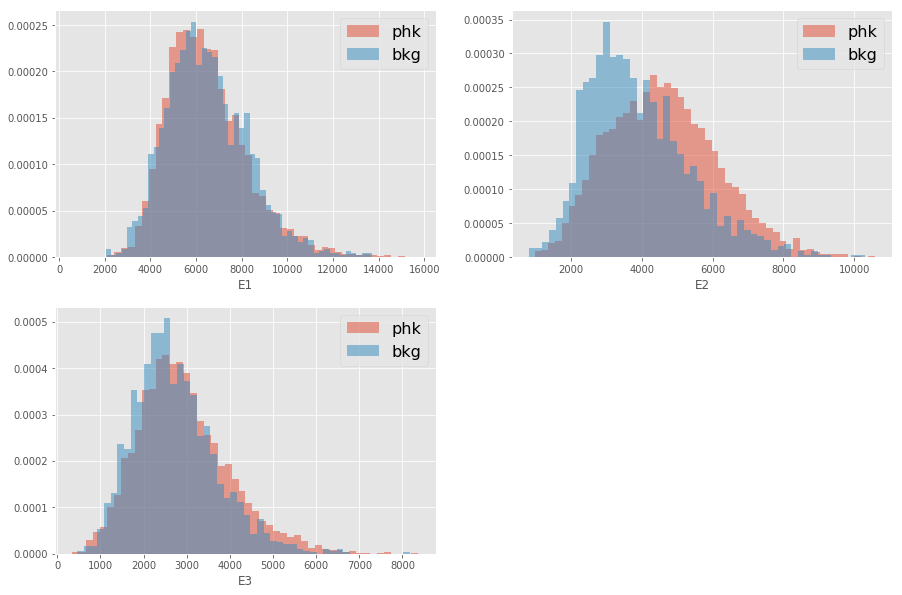

In [39]:
fig = plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

ax1.hist(bbdf_pk['E1'], bins=int(0.5*nbins), label='phk', alpha=0.5, density=True);
ax1.hist(bbdf_bk['E1'], bins=int(0.5*nbins), label='bkg', alpha=0.5, density=True);
ax1.set_xlabel('E1')
ax1.legend(fontsize=16);

ax2.hist(bbdf_pk['E2'], bins=int(0.5*nbins), label='phk', alpha=0.5, density=True);
ax2.hist(bbdf_bk['E2'], bins=int(0.5*nbins), label='bkg', alpha=0.5, density=True);
ax2.set_xlabel('E2')
ax2.legend(fontsize=16);

ax3.hist(bbdf_pk['E3'], bins=int(0.5*nbins), label='phk', alpha=0.5, density=True);
ax3.hist(bbdf_bk['E3'], bins=int(0.5*nbins), label='bkg', alpha=0.5, density=True);
ax3.set_xlabel('E3')
ax3.legend(fontsize=16);